# Defining `ufuncs` using `vectorize`

You have been able to define your own NumPy [`ufuncs`](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) for quite some time, but it's a little involved.  

You can read through the [documentation](http://docs.scipy.org/doc/numpy/user/c-info.ufunc-tutorial.html), the example they post there is a ufunc to perform 

$$f(a) = \log \left(\frac{a}{1-a}\right)$$

It looks like this:

```c
static void double_logit(char **args, npy_intp *dimensions,
                            npy_intp* steps, void* data)
{
    npy_intp i;
    npy_intp n = dimensions[0];
    char *in = args[0], *out = args[1];
    npy_intp in_step = steps[0], out_step = steps[1];

    double tmp;

    for (i = 0; i < n; i++) {
        /*BEGIN main ufunc computation*/
        tmp = *(double *)in;
        tmp /= 1-tmp;
        *((double *)out) = log(tmp);
        /*END main ufunc computation*/

        in += in_step;
        out += out_step;
    }
}
```

And **note**, that's just for a `double`.  If you want `floats`, `long doubles`, etc... you have to write all of those, too.  And then create a `setup.py` file to install it.  And I left out a bunch of boilerplate stuff to set up the import hooks, etc...

# Making your first ufunc

We can use Numba to define ufuncs without all of the pain.

In [1]:
%matplotlib inline
import numpy
import math

Let's define a function that operates on two inputs

In [2]:
def trig(a, b):
    return math.sin(a**2) * math.exp(b)

In [3]:
trig(1, 1)

2.2873552871788423

Seems reasonable.  However, the `math` library only works on scalars.  If we try to pass in arrays, we'll get an error.

In [4]:
a = numpy.ones((5,5))
b = numpy.ones((5,5))

In [5]:
trig(a, b)

TypeError: only length-1 arrays can be converted to Python scalars

In [6]:
from numba import vectorize

In [7]:
vec_trig = vectorize()(trig)

In [8]:
vec_trig(a, b)

array([[ 2.28735529,  2.28735529,  2.28735529,  2.28735529,  2.28735529],
       [ 2.28735529,  2.28735529,  2.28735529,  2.28735529,  2.28735529],
       [ 2.28735529,  2.28735529,  2.28735529,  2.28735529,  2.28735529],
       [ 2.28735529,  2.28735529,  2.28735529,  2.28735529,  2.28735529],
       [ 2.28735529,  2.28735529,  2.28735529,  2.28735529,  2.28735529]])

And just like that, the scalar function `trig` is now a NumPy `ufunc` called `vec_trig`

Note that this is a "Dynamic UFunc" with no signature given.  

How does it compare to just using NumPy?  Let's check

In [9]:
def numpy_trig(a, b):
    return numpy.sin(a**2) * numpy.exp(b)

In [10]:
a = numpy.random.random((1000, 1000))
b = numpy.random.random((1000, 1000))

In [11]:
%timeit vec_trig(a, b)

100 loops, best of 3: 19.2 ms per loop


In [13]:
%timeit numpy_trig(a, b)

10 loops, best of 3: 26.3 ms per loop


What happens if we do specify a signature?  Is there a speed boost?

In [14]:
vec_trig = vectorize('float64(float64, float64)')(trig)

In [15]:
%timeit vec_trig(a, b)

100 loops, best of 3: 20.9 ms per loop


No, not really.  But(!), if we have a signature, then we can add the target `kwarg`.

In [16]:
vec_trig = vectorize('float64(float64, float64)', target='parallel')(trig)

In [17]:
%timeit vec_trig(a, b)

100 loops, best of 3: 6.53 ms per loop


Automatic multicore operations!

**Note**: `target='parallel'` is not always the best option.  There is overhead in setting up the threading, so if the individual scalar operations that make up a `ufunc` are simple you'll probably get better performance in serial.  If the individual operations are more expensive (like trig!) then parallel is (usually) a good option.

### Passing multiple signatures

If you use multiple signatures, they have to be listed in order of most specific -> least specific

In [18]:
@vectorize(['int32(int32, int32)',
            'int64(int64, int64)',
            'float32(float32, float32)',
            'float64(float64, float64)'])
def trig(a, b):
    return math.sin(a**2) * math.exp(b)

In [19]:
trig(1, 1)

2

In [20]:
trig(1., 1.)

2.2873552871788423

In [21]:
trig.ntypes

4

## Exercise: Clipping an array

Yes, NumPy has a `clip` ufunc already, but let's pretend it doesn't.  

Create a Numba vectorized ufunc that takes a vector `a`, a lower limit `amin` and an upper limit `amax`.  It should return the vector `a` with all values clipped to be between $a_{min}$ and $a_{max}$:

In [23]:
def truncate(a, amin, amax):
    if a < amin:
        return amin
    elif a > amax:
        return amax
    else:
        return a

vec_truncate_serial = vectorize(['float64(float64, float64, float64)'])(truncate)
vec_truncate_par = vectorize(['float64(float64, float64, float64)'], target='parallel')(truncate)


In [24]:
a = numpy.random.random((5000))

In [25]:
amin = .2
amax = .6

In [26]:
%timeit vec_truncate_serial(a, amin, amax)

The slowest run took 6.36 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 11.8 µs per loop


In [29]:
%timeit vec_truncate_par(a, amin, amax)

The slowest run took 20.71 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 46.8 µs per loop


In [28]:
%timeit numpy.clip(a, amin, amax)

10000 loops, best of 3: 20.2 µs per loop


In [30]:
a = numpy.random.random((100000))

In [31]:
%timeit vec_truncate_serial(a, amin, amax)

The slowest run took 5.73 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 149 µs per loop


In [32]:
%timeit vec_truncate_par(a, amin, amax)

10000 loops, best of 3: 99.4 µs per loop


In [33]:
%timeit numpy.clip(a, amin, amax)

1000 loops, best of 3: 677 µs per loop


## Exercise: Monte Carlo in a Ufunc

A ufunc does not need to be deterministic.  Let's suppose your a simulating a tournament with the following rules:

  1. The player plays a sequence of games until they complete the tournament.
  2. The player has a fixed probability $p$ to win each game.
  3. Once the player has won 12 games or lost 3 games overall, they have completed the tournament.
  
What is the average number of wins per tournament for different values of $p$?

In [34]:
from numba import jit

MAX_WINS = 12
MAX_LOSSES = 3

@jit(nopython=True)
def run_tournament(p):
    '''Run one randomized tournament and return the number of wins'''
    wins = 0
    losses = 0
    
    while wins < 12 and losses < 3:
        if numpy.random.random() < p:
            wins += 1
        else:
            losses += 1
            
    return wins

In [35]:
# Let's test:
for i in range(3):
    print(run_tournament(0.5))

5
2
0


In [36]:
@vectorize
def avg_wins(p, trials):
    '''Return the average number of wins for the requested number of trials'''
    total_wins = 0
    for i in range(trials):
        total_wins += run_tournament(p)
    
    return total_wins / trials  # Note that this is a float in Python 3!

Test your implementation:

In [37]:
prob = numpy.linspace(0.0, 1.0, 1000)
results = avg_wins(prob, 100)

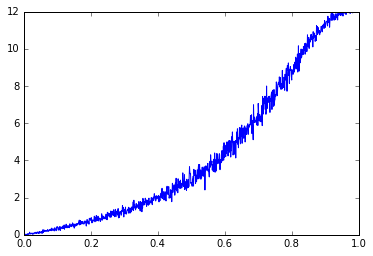

In [38]:
import matplotlib.pyplot as plt
plt.plot(prob, results)

## Performance of `vectorize` vs. regular array-wide operations

In [39]:
@vectorize
def discriminant(a, b, c):
    return b**2 - 4 * a * c

In [40]:
a = numpy.arange(10000)
b = numpy.arange(10000)
c = numpy.arange(10000)

In [41]:
%timeit discriminant(a, b, c)

The slowest run took 2447.45 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 18.1 µs per loop


In [42]:
%timeit b**2 - 4 * a * c

The slowest run took 22.45 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 37.1 µs per loop


What's going on?

* Each array operation creates a temporary copy
* Each of these arrays are loaded into and out of cache a whole bunch

In [ ]:
del a, b, c